In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy as sp
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from scipy.signal import detrend

In [6]:
time_df = pd.read_csv('arma_series02.csv')
time_df.head()

,Date,Y
0,15JUN2008,98.02
1,16JUN2008,100.34
2,17JUN2008,99.36
3,18JUN2008,100.84
4,19JUN2008,100.26


<Axes: xlabel='DATE'>

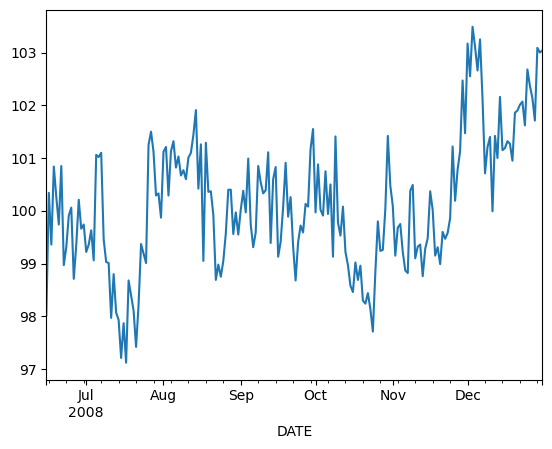

In [15]:
time_df['DATE'] = pd.to_datetime(time_df['Date'], format='%d%b%Y')

ar_ts_2 = pd.Series(time_df['Y'].values, index=time_df['DATE'])

ar_ts_2.plot()

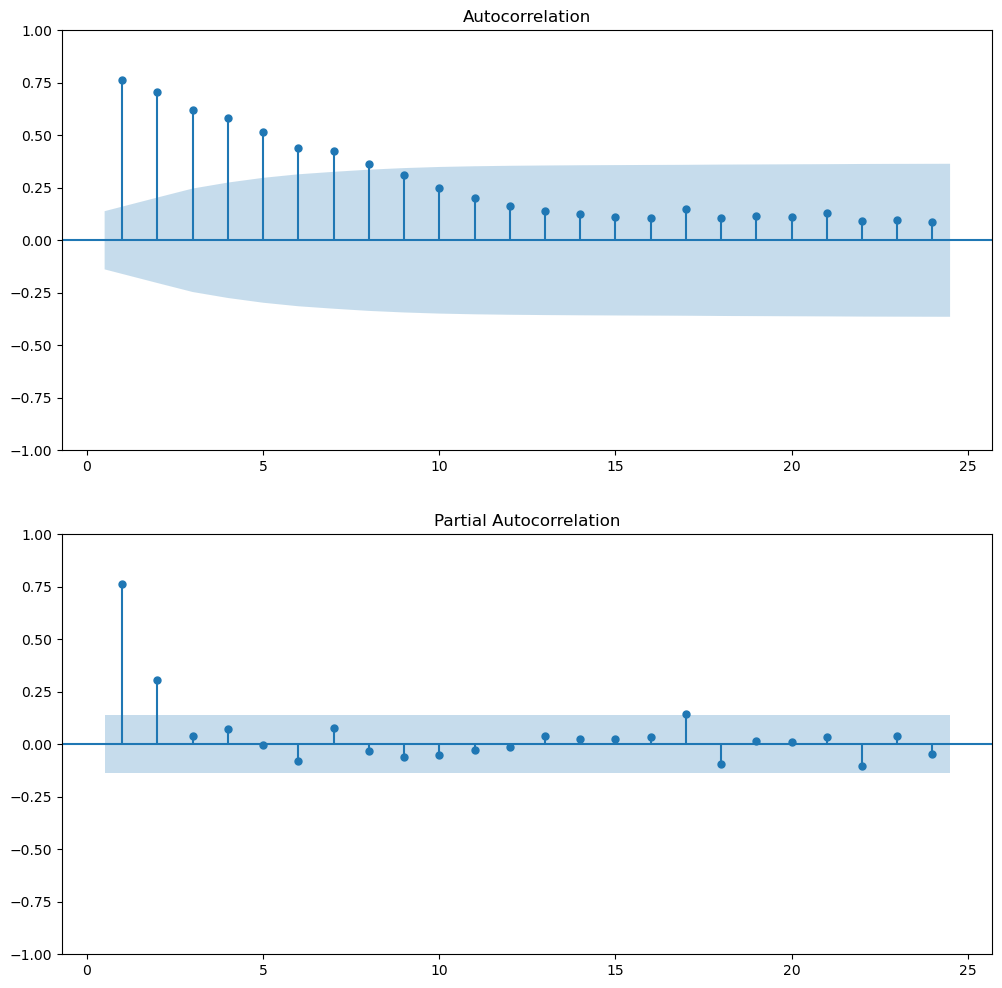

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))

plot_acf(ar_ts_2, ax=ax1, zero=False)
plot_pacf(ar_ts_2, ax=ax2, zero=False)
plt.show()

In [17]:
sm.stats.acorr_ljungbox(ar_ts_2, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,563.14271,1.378632e-114


In [18]:
adfuller(ar_ts_2, regression='c')

(-2.8620574499646,
 0.0499414543060636,
 1,
 198,
 {'1%': -3.4638151713286316,
  '5%': -2.876250632135043,
  '10%': -2.574611347821651},
 417.4713510923384)

In [19]:
fit_ar2 = ARIMA(ar_ts_2, order=(2,0,0)).fit()

print(fit_ar2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  200
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -227.765
Date:                Tue, 08 Oct 2024   AIC                            463.530
Time:                        19:00:40   BIC                            476.723
Sample:                    06-15-2008   HQIC                           468.869
                         - 12-31-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        100.1927      0.358    280.155      0.000      99.492     100.894
ar.L1          0.5332      0.071      7.489      0.000       0.394       0.673
ar.L2          0.3309      0.068      4.838      0.0

c:\Users\trush\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\trush\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\trush\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


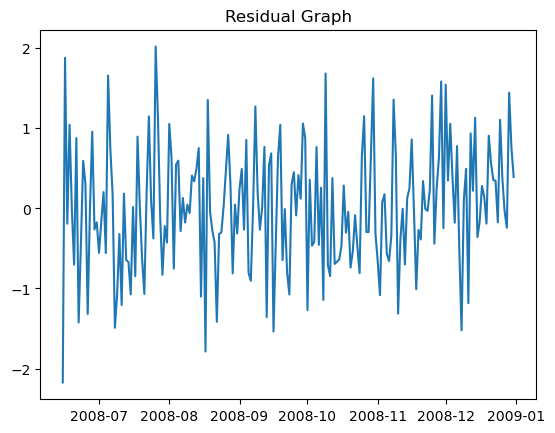

In [20]:
residuals = fit_ar2.resid
plt.plot(residuals)
plt.title('Residual Graph')
plt.show()

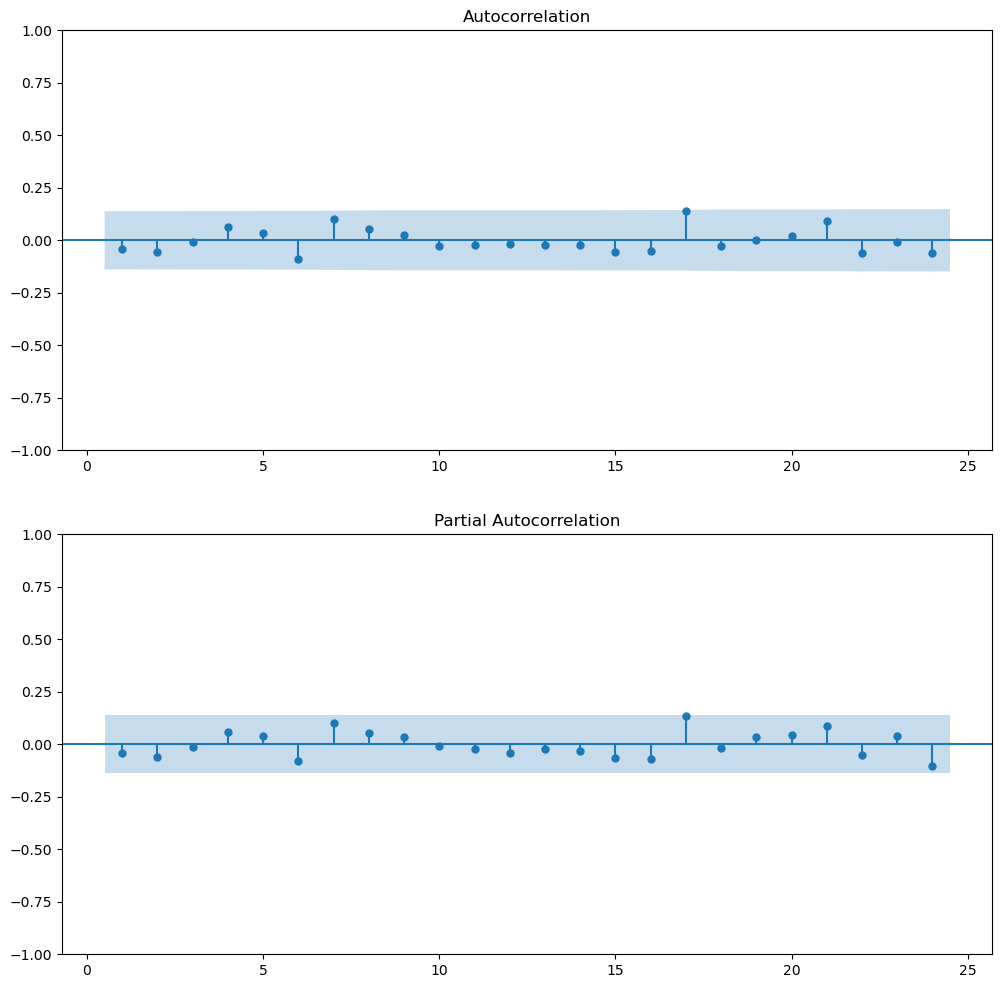

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))

plot_acf(residuals, ax=ax1, zero=False)
plot_pacf(residuals, ax=ax2, zero=False)
plt.show()

In [22]:
sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,6.843747,0.740109


In [23]:
adfuller(residuals, regression='c')

(-14.907600257884777,
 1.474862456228917e-27,
 0,
 199,
 {'1%': -3.4636447617687436,
  '5%': -2.8761761179270766,
  '10%': -2.57457158581854},
 415.6541270300031)

In [25]:
pred = fit_ar2.get_prediction()

In [26]:
predicted_mean = pred.predicted_mean
conf_int = pred.conf_int()

pred_df = pd.DataFrame({
    'predicted mean': predicted_mean,
    'lower bound': conf_int.iloc[:,0],
    'upper bound': conf_int.iloc[:,1]
})

pred_df.head()

,predicted mean,lower bound,upper bound
2008-06-15,100.192680,97.602405,102.782955
2008-06-16,98.461196,96.896500,100.025892
2008-06-17,99.552283,98.075736,101.028830
2008-06-18,99.797424,98.320877,101.273970
2008-06-19,100.262308,98.785762,101.738855


In [30]:
prediction_df = pd.concat([pred_df, ar_ts_2.to_frame(name='Y')], axis=1)
prediction_df.head()

,predicted mean,lower bound,upper bound,Y
2008-06-15,100.192680,97.602405,102.782955,98.02
2008-06-16,98.461196,96.896500,100.025892,100.34
2008-06-17,99.552283,98.075736,101.028830,99.36
2008-06-18,99.797424,98.320877,101.273970,100.84
2008-06-19,100.262308,98.785762,101.738855,100.26


In [32]:
#errors
errors = prediction_df['Y'] - prediction_df['predicted mean']

errors_abs = errors.abs()

mape = ((errors_abs/prediction_df['Y'].abs()).mean()) * 100

rmse = (errors ** 2).mean()**0.5

print(f'mape % = {mape}')
print(f'rmse = {rmse}')


mape % = 0.6069574064746425
rmse = 0.7651244537975791


In [33]:
forecast = fit_ar2.get_forecast(steps=14)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

forecast_df = pd.DataFrame({
    'Forecasted Y': mean_forecast,
    'lower bound': confidence_intervals.iloc[:,0],
    'upper bound': confidence_intervals.iloc[:,1]
})

forecast_df

,Forecasted Y,lower bound,upper bound
2009-01-01,102.639899,101.163352,104.116446
2009-01-02,102.439791,100.766447,104.113136
2009-01-03,102.200693,100.296668,104.104718
2009-01-04,102.006984,99.962424,104.051543
2009-01-05,101.824574,99.664211,103.984937
2009-01-06,101.663209,99.416028,103.910391
2009-01-07,101.516805,99.200715,103.832896
2009-01-08,101.385342,99.015111,103.755573
2009-01-09,101.266797,98.853450,103.680144
2009-01-10,101.160084,98.712352,103.607817


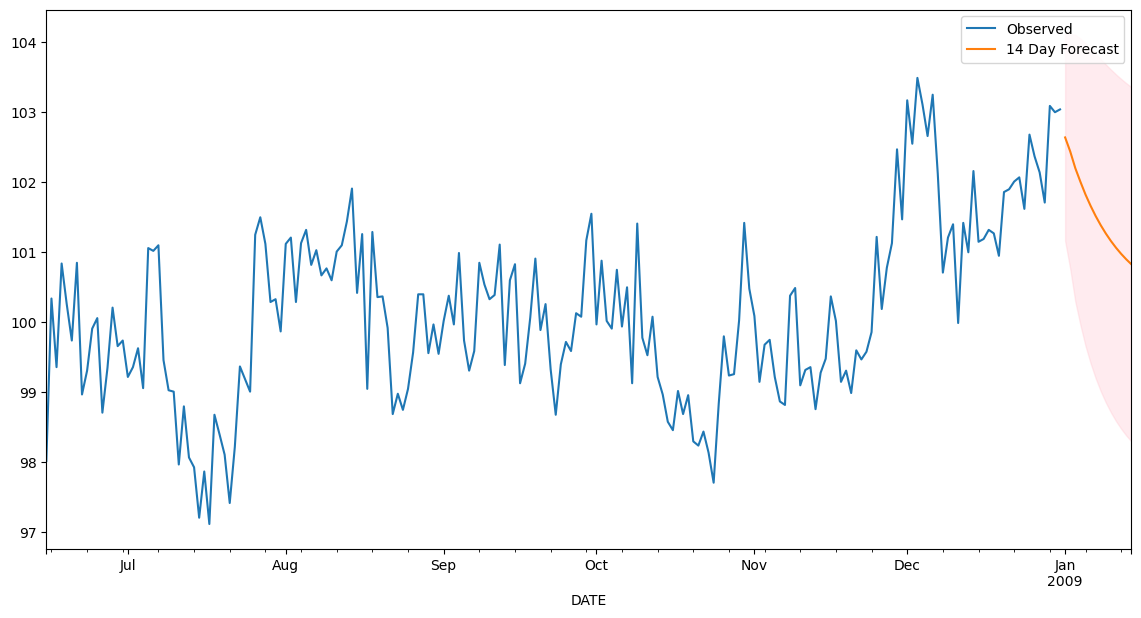

In [34]:
plt.figure(figsize=(14,7))
ar_ts_2.plot(label='Observed', legend=True)
mean_forecast.plot(label='14 Day Forecast', legend=True)
plt.fill_between(confidence_intervals.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.show()